# Code to compute the agreement and the accuracy of Home Detection Algorithms (HDAs)

based on the paper:

```Luca Pappalardo, Leo Ferres, Manuel Sacasa, Ciro Cattuto, Loreto Bravo, An individual-level ground truth dataset forhome location detection, Arxiv```

In [198]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

In [199]:
legend_fontsize = 22
x_params_fontsize = 25
y_params_fontsize = 25
y_label_fontsize = 25
text_fontsize=20

hda2color = {'HDA1': 'darkgrey', 'HDA2': 'grey', 'HDA3': 'k', 'HDA4':'lightgrey', 'HDA5':'w'}
hda2hatch = {'HDA1':'', 'HDA2':'', 'HDA3':'', 'HDA4':'//', 'HDA5':'//'}

# Load the activity dataset and the ground truth dataset

In [174]:
activity_df = pd.read_csv('complete_dataset_h.csv').sort_values(by=['device', 'stream', 'algorithm', 'activity'],
                                                                ascending=False)
activity_df.head()

(260400, 5)


,device,tower,activity,stream,algorithm
113314,fddef72025c2b9d62691814364a74214fdf550cc249a61...,-7454916592300775789,301,XDR,HDA5
113315,fddef72025c2b9d62691814364a74214fdf550cc249a61...,7114568381187596572,296,XDR,HDA5
113316,fddef72025c2b9d62691814364a74214fdf550cc249a61...,1959244915681524707,296,XDR,HDA5
113317,fddef72025c2b9d62691814364a74214fdf550cc249a61...,-1737146831410450117,60,XDR,HDA5
113318,fddef72025c2b9d62691814364a74214fdf550cc249a61...,4684068318733381362,11,XDR,HDA5


In [100]:
gt_df = pd.read_csv('ground_truth_dataset_h.csv')
gt_df.head()

,device,closest_tower,2nd_closest_tower,3rd_closest_tower
0,fddef72025c2b9d62691814364a74214fdf550cc249a61...,7114568381187596572,1959244915681524707,-1737146831410450117
1,fdb7cfdb93061b594f4240bcedf9fb7ed74a1b802f7cf1...,1754121771819590262,962172976778950906,-1590560817795929930
2,f1599de213ed4347faa13c7556f81b31bafb673fcdb293...,-6525451587682932100,-4972404575620375551,7722192524578932062
3,ebb20a080850fa59d0b34b8fabf60544b0caf612155e44...,3165853637381081103,-8284686374220562699,8029823201868626648
4,e2e32692e944ef56a14af251c24c6ea03bd6377b8e7194...,2775798891950922339,-1576305466966117115,992689247108936208


# Simple Matching Coefficient

One intriguing question is whether, for the same individual user, different HDAs would detect different home locations ($L_1$ cell towers). We assess to which degree two different algorithms detect similar home locations for all individual users in the dataset by evaluating the **Simple Matching Coefficient** (SMC):

$$SMC_T(X, Y) = 100 * \frac{\sum_{i=u}^N \delta(H_{X, T}(u), H_{Y, T}(u))}{N}$$


where $i=1 \dots N$ denotes the $N$ users analysed, and $\delta(H_{X, T}(u), H_{Y, T}(u))$ is the Kronecker delta which is equal to 1 when the home detected by algorithm $X$ for the $i$-th user is identical to the home detected by algorithm $Y$ for the same user. The Kronecker delta becomes 0 otherwise. 

Values of SMC thus range between 0 and 100 and can be interpreted as the percentage of individual   cases   for   which   both   algorithms   detectedthe   same   home   locations.

In [101]:
def SMC(df_algos):
    """
    Compute the Simple Matching Coefficient (SMC) of two Home Detection Algorithms (HDAs).
    
    Parameters
    ----------
    df_algos: pandas DataFrame
        the DataFrame with the results of the home detection according to the 
        two HDAs.
        
    Returns
    -------
    SMC: float
        the SCM computed for the two algorithms' results.
    """
    #print(df_algos.head())
    N = len(df_algos)
    SMC = 100 * (df_algos.tower1 == df_algos.tower2).sum()/N
    return SMC

In [102]:
def compute_SMCs(activity_df):
    """
    Compute the Simple Matching Coefficient (SMC) between two Home Detection Algorithms (HDAs).
    
    Parameters
    ----------
    activity_df : pandas DataFrame
        a DataFrame of the activity of users according to a stream and HDA. The DataFrame should have the following header:
        "device,tower,activity,stream,algorithm"
        
    Returns
    -------
    pandas DataFrame
        a DataFrame with the result of the computation, with the followin format:
        "device,hda_i,hda_j,smc"
        
    """
    results = []
    streams = activity_df['stream'].unique()
    
    # for each of the three streams (CDRs, XDRs, CPRs) separately
    for stream in streams:
        stream_df = activity_df[activity_df['stream'] == stream]
        
        # for each of the five HDAs separately
        for hda_i in range(1, 6):
            hda_name_i = 'HDA%s' %hda_i
            stream_hda_i_df = stream_df[stream_df['algorithm'] == hda_name_i].sort_values(by=['device', 'activity'], ascending=False)
            users_home_i_df = stream_hda_i_df.groupby('device').head(1).reset_index()
            
            for hda_j in range(1, 6):
                if hda_i != hda_j:
                    hda_name_j = 'HDA%s' %hda_j
                    stream_hda_j_df = stream_df[stream_df['algorithm'] == hda_name_j].sort_values(by=['device', 'activity'], ascending=False)
                    users_home_j_df = stream_hda_j_df.groupby('device').head(1).reset_index()
                    
                    smc = SMC(pd.merge(users_home_i_df, users_home_j_df, on='device', suffixes=(1, 2)))
                    results.append([stream, hda_name_i, hda_name_j, smc])
    
    res_df = pd.DataFrame(results, columns=['stream', 'hda_i', 'hda_j', 'smc'])
    return res_df

In [103]:
smc_df = compute_SMCs(activity_df)
smc_df.head()

,stream,hda_i,hda_j,smc
0,XDR,HDA1,HDA2,75.384615
1,XDR,HDA1,HDA3,84.615385
2,XDR,HDA1,HDA4,18.461538
3,XDR,HDA1,HDA5,18.461538
4,XDR,HDA2,HDA1,75.384615


In [104]:
def plot_SMCs(smc_df, stream='CDR'):
    """
    Plot the SMC of a data type.
    """
    hda2marker = {'HDA1': 'o', 'HDA2': 'v', 
                        'HDA3': 's', 'HDA4':'d', 
                        'HDA5':'h'}
    stream_df = smc_df[smc_df['stream'] == stream]
    
    fig = plt.figure(figsize=(9,7))
    ax = plt.axes()
    
    hda2flag = {'HDA%s'%i: True for i in range(1, 6)}
    for i, hda in enumerate(stream_df['hda_i'].unique()):    
        stream_hda_df = stream_df[stream_df['hda_i'] == hda]
        for _, row in stream_hda_df.iterrows():
            hda_j = row['hda_j']
            ax.scatter([i], row['smc'], 
                       marker=hda2marker[hda_j], color='whitesmoke', edgecolor='k', s=200,
                      label=hda_j if hda2flag[hda_j] else "")
            if hda2flag[hda_j]:
                hda2flag[hda_j] = False

    ax.set_ylabel('SMC (%)', fontsize=y_label_fontsize)
    ax.set_xticks(range(5))
    ax.set_xticklabels(['HDA1','HDA2','HDA3','HDA4', 'HDA5'])
    ax.tick_params(axis="x", labelsize=x_params_fontsize, rotation=90)
    ax.tick_params(axis='y', labelsize=y_params_fontsize)
    ax.set_ylim(0, 100)
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(loc=1, ncol=2, fontsize=legend_fontsize,
             columnspacing=0.5, handletextpad=0.1)
    ax.set_title('%ss' %stream, fontsize=22)
    fig.tight_layout()
    #plt.savefig(plots_folder + 'smc_plots_%s.pdf' %name)
    plt.show()

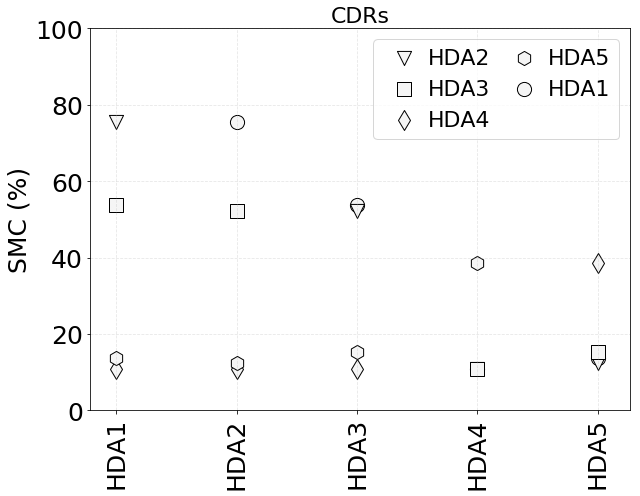

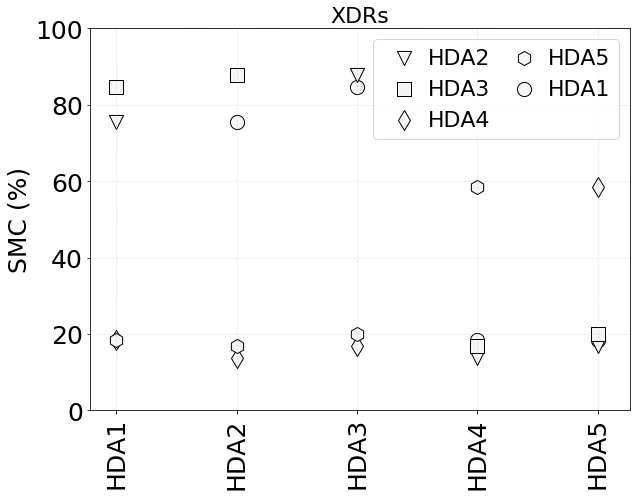

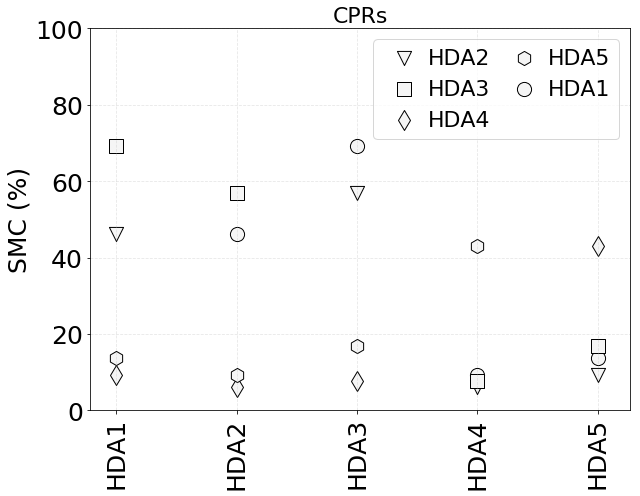

In [105]:
plot_SMCs(smc_df, stream='CDR')
plot_SMCs(smc_df, stream='XDR')
plot_SMCs(smc_df, stream='CPR')

In [106]:
def plot_avg_SMC(smc_df):
       
    width = 0.15
    fig, ax = plt.subplots(figsize=(9,7))
    
    for i, stream in enumerate(smc_df['stream'].unique()):
        stream_df = smc_df[smc_df['stream'] == stream]
        avg_smcs = stream_df.groupby('hda_i').mean().reset_index()
        for j, row in avg_smcs.iterrows():
            ax.bar(i + (j * width), row['smc'], width=width - 0.025, 
                   color=hda2color[row['hda_i']], edgecolor='k', linewidth=2,
                   label=row['hda_i'] if i == 0 else "", hatch=hda2hatch[row['hda_i']], 
                  alpha=0.75)

        # plot means by data type
        plt.hlines(avg_smcs['smc'].mean(), i-width/2, i+width * 5, color='k', linewidth=3, 
                      linestyle='--', label='avg' if i==0 else "")
    
        plt.text(i + width*3, avg_smcs['smc'].mean() + 1, '%s%%' %round(avg_smcs['smc'].mean(), 2),
            fontsize=text_fontsize)

    ax.set_xticks(np.arange(3) + 4*width / 2)
    ax.set_xticklabels(('CDRs', 'XDRs', 'CPRs'), fontsize=22)
    ax.tick_params(axis='y', labelsize=15)

    plt.ylim(0, 100)
    plt.grid(alpha=0.25, linestyle='--', axis='y')
    plt.ylabel('avg SMC (%)', fontsize=y_label_fontsize)
    plt.legend(fontsize=legend_fontsize, ncol=2, loc=9)
    fig.tight_layout()
    #plt.savefig(plots_folder + 'smc_bars.pdf')
    plt.show()

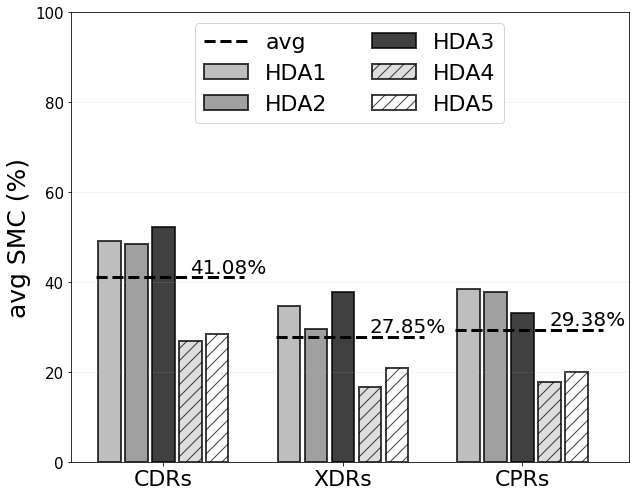

In [107]:
plot_avg_SMC(smc_df)

## Accuracy of HDAs
here we compute the accuracy of each HDA with respect to the ground truth. Note that, for each user $u$, we know the exact position of their home $H^{(u)}$. We hence compute the three closest towers to that location. Given location $H_{X, T}(u)$, indicating the home location  of user $u$ identified by algorithm $i$ on data type $d$, we say that the home location is correct if $H_{X, T}(u)$ is one of the three closest towers to the user's ground truth home location. 

In [179]:
def check_detection(user_df, criterion='any', k=1):
    n_records = len(user_df)
    highest_activity_locations = [user_df['tower'].iloc[i] for i in range(min(k, n_records))]
    
    if criterion == 'any':
        ground_truth_towers = [user_df.iloc[0]['closest_tower'], 
                               user_df.iloc[0]['2nd_closest_tower'],
                               user_df.iloc[0]['3rd_closest_tower']]
    elif criterion == 'closest_tower':
        ground_truth_towers = [user_df.iloc[0]['closest_tower']]

    return int(not set(highest_activity_locations).isdisjoint(ground_truth_towers))

def compute_accuracy(activity_df, gt_df):
    df = pd.merge(activity_df, gt_df, on='device')
    n_devices = len(df['device'].unique())
    results = []
    streams = df['stream'].unique()
    
    # for each of the three streams (CDRs, XDRs, CPRs) separately
    for stream in streams:
        stream_df = df[df['stream'] == stream]
        
        # for each of the five HDAs separately
        for hda_i in range(1, 6):
            hda_name_i = 'HDA%s' %hda_i
            stream_hda_i_df = stream_df[stream_df['algorithm'] == hda_name_i].sort_values(by=['device', 'activity'], ascending=False)
            # compute the number of users for which the correct tower is detected
            for criterion in ['any', 'closest_tower']:
                for k in range(1, 4):
                    correct_towers = stream_hda_i_df.groupby('device').apply(lambda user_df: check_detection(user_df, criterion=criterion, k=k)).sum()
                    results.append([stream, hda_name_i, correct_towers/n_devices, criterion, k])

    result_df = pd.DataFrame(results, columns=['stream', 'algorithm', 'accuracy', 'criterion', 'k'])
    return result_df.sort_values(by=['criterion', 'k', 'stream', 'algorithm'])

In [180]:
acc_df = compute_accuracy(activity_df, gt_df)
acc_df.head()

,stream,algorithm,accuracy,criterion,k
60,CDR,HDA1,0.246154,any,1
66,CDR,HDA2,0.353846,any,1
72,CDR,HDA3,0.430769,any,1
78,CDR,HDA4,0.169231,any,1
84,CDR,HDA5,0.261538,any,1


In [193]:
def plot_accuracy(acc_df, criterion='any', k=1, legend=True):
    width = 0.15
    fig, ax = plt.subplots(figsize=(9,7))
    acc_df_cr_k = acc_df[(acc_df['criterion'] == criterion) & (acc_df['k'] == k)]
    
    for i, stream in enumerate(acc_df_cr_k['stream'].unique()):
        stream_df = acc_df_cr_k[acc_df_cr_k['stream'] == stream].reset_index()
        avg_accs = stream_df.groupby('stream').mean().reset_index()
        for j, row in stream_df.iterrows():
            ax.bar(i + (j * width), row['accuracy'], width=width - 0.025, 
                   color=hda2color[row['algorithm']], edgecolor='k', linewidth=2,
                   label=row['algorithm'] if i == 0 else "", hatch=hda2hatch[row['algorithm']], 
                  alpha=0.75)

        # plot means by data type
        plt.hlines(avg_accs['accuracy'].mean(),  i-width/2, i+width * 5, color='k', linewidth=3, 
                      linestyle='--', label='avg' if i==0 else "")
    
        plt.text(i + width*3, avg_accs['accuracy'].mean() + 0.01, '%s%%' %round(avg_accs['accuracy'].mean(), 2),
            fontsize=text_fontsize)
    
    ax.set_xticks(np.arange(3) + 4*width / 2)
    ax.set_xticklabels(('CDRs', 'XDRs', 'CPRs'), fontsize=x_params_fontsize)
    ax.tick_params(axis='y', labelsize=y_params_fontsize)
    plt.ylim(0, 1)
    tower2name = {'near0': 'nearest', 'near1': 'second nearest', 'near2': 'third nearest'}
    plt.grid(alpha=0.25, linestyle='--', axis='y')
    if criterion == 'any':
        if k == 1:
            plt.ylabel('Acc$(X, T)$', fontsize=y_label_fontsize)
        else:
            plt.ylabel('Acc$^{(%s)}(X, T)$' %k, fontsize=y_label_fontsize)
    else:
        if k == 1:
            plt.ylabel('Acc$_{%s}(X, T)$' %criterion.replace('_', ''), fontsize=y_label_fontsize)
        else:
            plt.ylabel('Acc$_{%s}^{(%s)}(X, T)$' %(criterion.replace('_', ''), k), fontsize=y_label_fontsize)
    if legend:
        plt.legend(ncol=3, loc=9, fontsize=legend_fontsize)
    fig.tight_layout()
    #plt.savefig(plots_folder + '%s_accuracy_%s_tower.pdf' %(k, tower))
    plt.show()

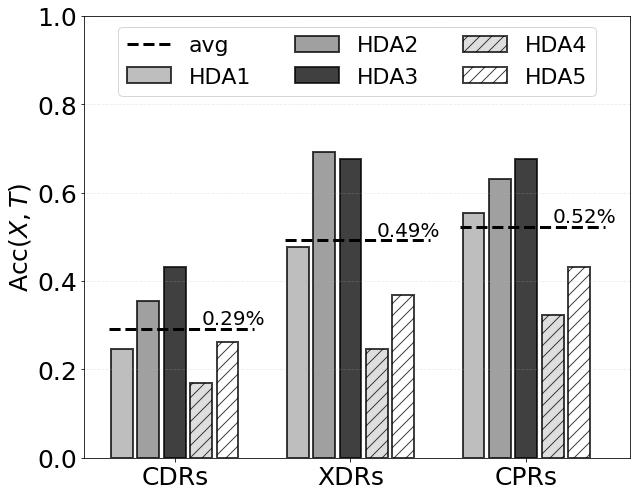

In [194]:
plot_accuracy(acc_df)

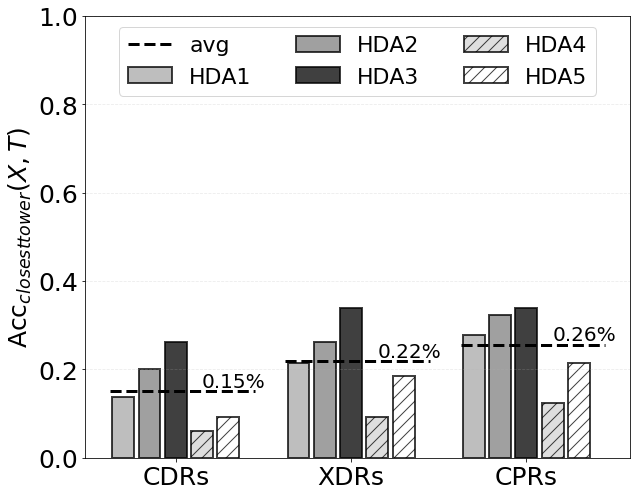

In [195]:
plot_accuracy(acc_df, criterion='closest_tower')

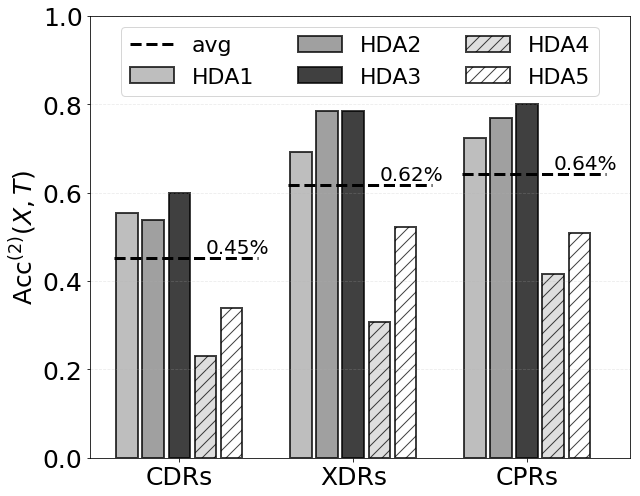

In [196]:
plot_accuracy(acc_df, k=2)

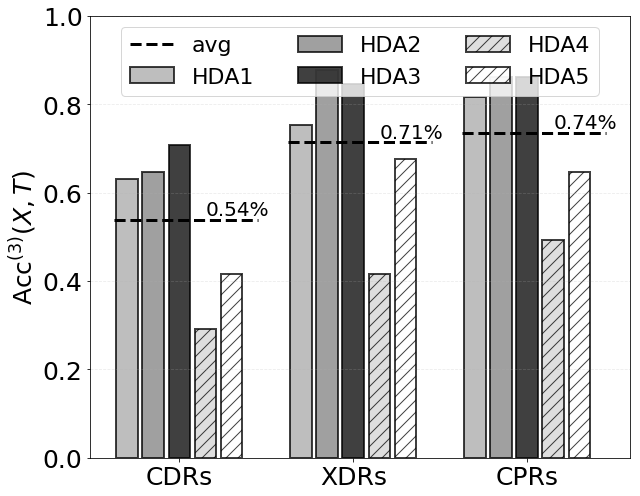

In [197]:
plot_accuracy(acc_df, k=3)